In [2]:
import numpy as np
import datetime

import matplotlib.pyplot as plt

from scipy.optimize import minimize

import astropy.units as u
from astropy.wcs import WCS
from astropy.time import Time
from astropy.table import Table, join
from astropy.io import fits
from astropy.visualization.wcsaxes.frame import EllipticalFrame

from photutils import CircularAperture

from skycam_utils.pipeline import get_ut
from skycam_utils.astrometry import update_altaz, load_wcs
from skycam_utils.photometry import load_skycam_catalog
from skycam_utils.fit_wcs import wcs_zea, wcs_refine_zea
from skycam_utils.fisheye_map import Fisheye, distortion_mapper, distortion_mapper_looper

Load the curated skycam catalog that contains photometry, names, positions, and other info for naked eye stars into `skycat`. Then load the catalog for the calibration image into `srccat`. This catalog is created using `photutils` to find sources and measure their properties. For the calibration image, the sources will need to be hand-labeled so they can be cross-referenced with `skycat`. Once an initial WCS is built from this, it should be possible to make refined or updated WCS's from that without having to do the hand-labeling step. The `id` column created by `photutils` needs to be renamed to `Star Name` to match the name used in `skycat`.

In [3]:
skycat = load_skycam_catalog()
srccat = Table.read("sources.csv")
srccat

Star Name,xcentroid,ycentroid,source_sum,background_mean,obs_mag
str16,float64,float64,float64,str4,float64
Arcturus,254.19772610251502,189.95417810224342,2795.454510500938,None,-8.616131073807274
Spica,302.0067782895859,96.49846533553992,2366.2754543887604,None,-8.435163246923684
Regulus,446.4230498059981,204.0569593099036,1708.0437958975294,None,-8.081247505567442
Alioth,305.62038797113473,310.3742837921076,1681.338069010464,None,-8.06413761605548
Rasalhague,131.22452731441697,212.94007659885582,1677.3270540975311,None,-8.061544379743154
Alphecca,200.5776488535487,225.25726442577033,1627.8241128159057,None,-8.029018693397456
Dubhe,346.3925115420019,339.04947270480244,1589.241026068661,None,-8.002974419471489
Yed Prior,164.57002723733137,135.04377489037273,1584.2897764684008,None,-7.999586549212109
Kochab,273.7840248040686,366.8748108635814,1530.5336485408993,None,-7.962107204835016


This is an example of a clear, dark image and its header. The `UT` is needed to calculate the Alt/Az for the catalog stars.

In [4]:
hdul = fits.open("image_0003000.fits.gz")
im = hdul[0].data
hdr = hdul[0].header
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  640                                                  
NAXIS2  =                  480                                                  
EXTEND  =                    T                                                  
GAIN    =                   91                                                  
FRAME   = '256 Frames'                                                          
UT      = 'WED MAR 16 08:38:49 2016'                                            
LST     = '12:52:46.098'                                                        
AZ      =         203.99355633                                                  
EL      =           58.0031977                                                  
SCOPEX  =                  3

I don't understand why people don't simply use ISO format for time strings. It is so much easier and universally understood. So we parse what we have into `datetime` and make a `Time` object from that.

In [5]:
tobs = get_ut(hdr, year=2016)
tobs

<Time object: scale='utc' format='datetime' value=2016-03-16 08:38:49>

Use the `update_altaz` function to update the `Alt` and `Az` columns in `skycat` based on `tobs`. The columns will be added if they don't exist.

In [6]:
skycat = update_altaz(skycat, time=tobs)

Join the catalogs based on `Star Name` and keep the most relevant columns.

In [7]:
joint = join(skycat, srccat, keys='Star Name', join_type='inner')
joint.keep_columns(['Star Name', 'Identity', 'xcentroid', 'ycentroid', 'Magnitude', 'obs_mag', 'background_mean', 'RA', 'Dec', 'Alt', 'Az'])
joint.sort('Magnitude')
joint

Star Name,Identity,Magnitude,RA,Dec,Alt,Az,xcentroid,ycentroid,background_mean,obs_mag
,,,,,deg,deg,,,,
str17,str25,float64,float64,float64,float64,float64,float64,float64,str4,float64
Arcturus,Alpha Bodtis,-0.04,213.9153003,19.1824092,67.36552167039491,118.75386974682698,254.19772610251502,189.95417810224342,None,-8.616131073807274
Spica,Alpha Virginis,0.98,201.29825,-11.1613833,46.329789441074176,168.12681909731708,302.0067782895859,96.49846533553992,None,-8.435163246923684
Regulus,Alpha Leonis,1.35,152.0929625,11.9672089,47.54429349869,251.56594706332297,446.4230498059981,204.0569593099036,None,-8.081247505567442
Alioth,Epsilon Ursae Majoris,1.77,193.507,55.9597167,65.8161724426088,0.6846359336487379,305.62038797113473,310.3742837921076,None,-8.06413761605548
Dubhe,Alpha Ursae Majoris,1.79,165.9319647,61.7510347,55.30797476313052,337.75051537818433,346.3925115420019,339.04947270480244,None,-8.002974419471489
Alkaid,Eta Ursae Majoris,1.86,206.8851572,49.3132667,69.60583586433098,26.674595357315415,279.0329404260496,288.18707350690624,None,-7.910374458034715
Polaris,Alpha Ursae Minoris,2.02,37.953,89.2641667,31.10996742859025,359.6165762330519,297.9211239817743,407.5584911941718,None,-7.673123141022856
Rasalhague,Alpha Ophiuchi,2.08,263.7336228,12.5600375,22.843583851841,89.02468482653974,131.22452731441697,212.94007659885582,None,-8.061544379743154


In [8]:
wcs_initial = load_wcs(year=2015)
wcs_initial

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA-SIP'  'DEC--ZEA-SIP'  
CRVAL : 0.0  90.0  
CRPIX : 316.4530304235  234.59822031801  
PC1_1 PC1_2  : 0.29922819398703  0.032460943221853  
PC2_1 PC2_2  : -0.032890924326855  0.30328831560446  
CDELT : 1.0  1.0  
NAXIS : 0  0

The residuals look pretty good, too. The only significant outliers are the ones at the very edge of the field of view. 

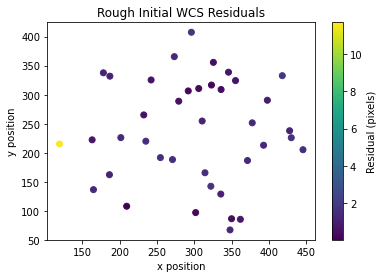

In [9]:
fit_x, fit_y = wcs_initial.all_world2pix(joint['Az'], joint['Alt'], 0)
resid_d = ((fit_x-joint['xcentroid'])**2+(fit_y-joint['ycentroid'])**2)**0.5
plt.scatter(fit_x, fit_y, c=resid_d)
cb = plt.colorbar()
cb.set_label('Residual (pixels)')
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Rough Initial WCS Residuals')
plt.show()

In [10]:
resid_d[resid_d < 10].mean()

1.0484127591524655

In [23]:
ax.coords

<CoordinatesMap with 2 world coordinates:

  index           aliases              type   unit wrap format_unit visible
  ----- --------------------------- --------- ---- ---- ----------- -------
      0   pos.eq.ra ra---zea-sip ra longitude  deg  360         deg     yes
      1 pos.eq.dec dec--zea-sip dec  latitude  deg None         deg     yes

>

In [14]:
wcs_fits = wcs_initial.to_fits()
wcs_fits.writeto("wcs_2016.fits")

In [44]:
test = WCS("wcs.fits")

In [15]:
joint.write("astrometry.csv")

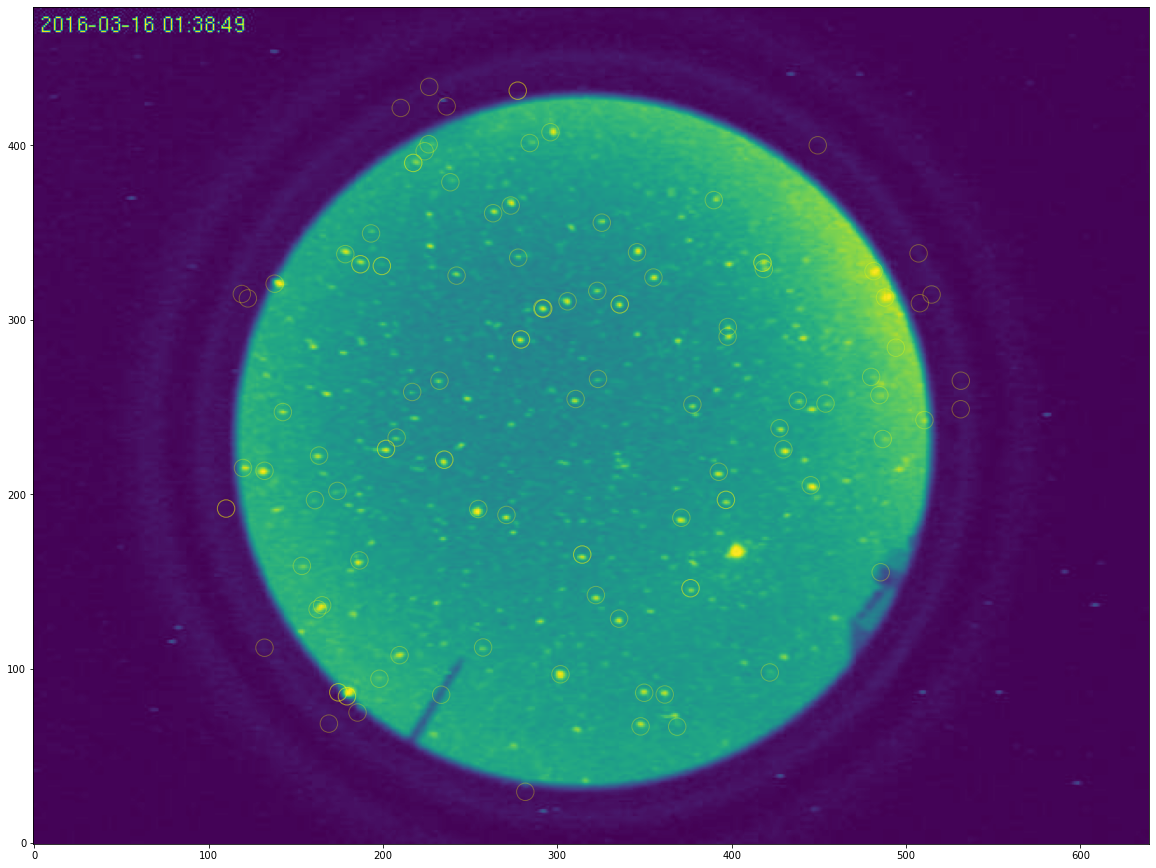

In [12]:
plt.figure(figsize=[20,20])
skycat = skycat[skycat['Alt'] > 10.0]
pred_x, pred_y = wcs_initial.all_world2pix(skycat['Az'], skycat['Alt'], 0)
pred_aps = CircularAperture((pred_x, pred_y), r=5.)
aps = CircularAperture((joint['xcentroid'], joint['ycentroid']), r=5.)
ax = plt.subplot()
ax.imshow(im, origin='lower')
#aps.plot(color='red', lw=1.5, alpha=0.5)
pred_aps.plot(color='yellow', lw=1., alpha=0.3)
plt.show()